<a href="https://colab.research.google.com/github/2303A52144/ExplainableAI_Assignment/blob/main/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target: co2
Training Linear
Training RandomForest
Training GradientBoosting
Results:
                          MAE        RMSE        R2
Linear            185.472465  391.012214  0.980300
RandomForest       99.087388  577.999400  0.956954
GradientBoosting  120.353811  462.539942  0.972434
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MLP: {'MAE': 543.6838774736287, 'RMSE': np.float64(2753.013982326726), 'R2': 0.023445669880959974}


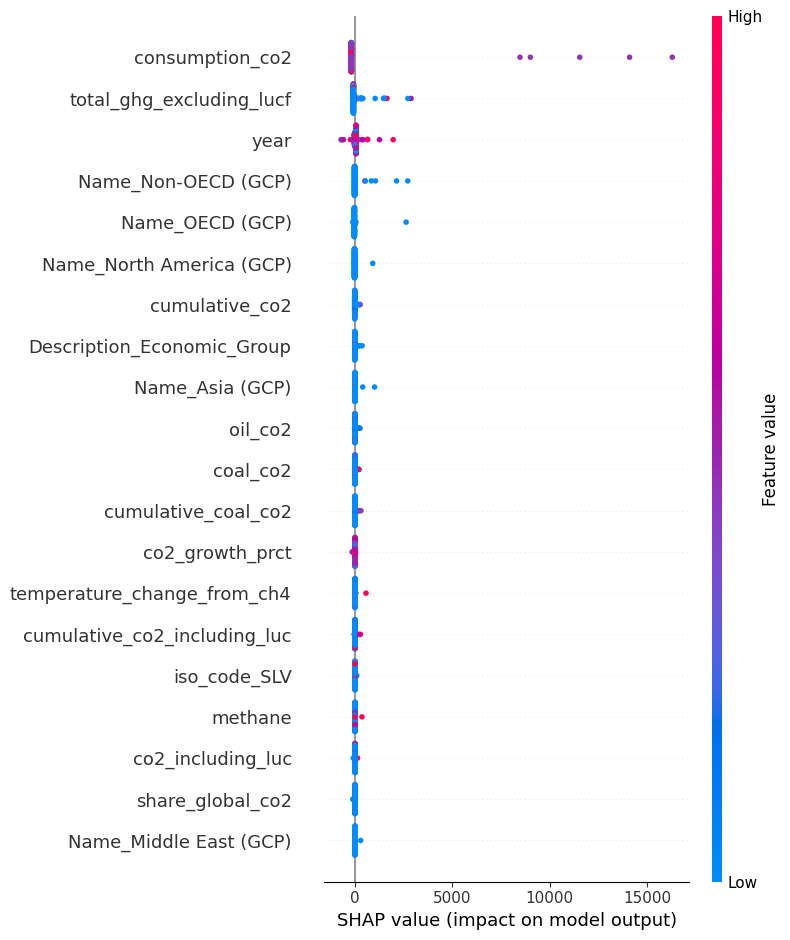

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shap

# -----------------------------
# 1. Load dataset
# -----------------------------
DATA_PATH = "/content/Data.csv"  # change if needed
raw = pd.read_csv(DATA_PATH)

# sample data for speed
if len(raw) > 2000:
    raw = raw.sample(2000, random_state=42)

POSSIBLE_TARGETS = ['co2', 'co2_emissions', 'emissions', 'CO2', 'Total']
for t in POSSIBLE_TARGETS:
    if t in raw.columns:
        TARGET = t
        break
else:
    TARGET = raw.select_dtypes(include=[np.number]).columns[-1]

print("Target:", TARGET)

# -----------------------------
# 2. Preprocessing
# -----------------------------
cat_cols = [c for c in raw.columns if raw[c].dtype == 'object' and c != TARGET]
num_cols = [c for c in raw.columns if raw[c].dtype in [np.float64, np.int64] and c != TARGET]

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
])

df = raw.dropna(subset=[TARGET])
X = df.drop(columns=[TARGET])
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor.fit(X_train)
X_train_p = preprocessor.transform(X_train)
X_test_p = preprocessor.transform(X_test)

feature_names = num_cols
if len(cat_cols) > 0:
    cat_ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    feature_names += list(cat_ohe.get_feature_names_out(cat_cols))

# -----------------------------
# 3. Evaluation util
# -----------------------------
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# -----------------------------
# 4. Train fast ML models
# -----------------------------
models = {
    'Linear': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=50, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=50, random_state=42),
}

results = {}
for name, model in models.items():
    print("Training", name)
    model.fit(X_train_p, y_train)
    preds = model.predict(X_test_p)
    results[name] = regression_metrics(y_test, preds)

print("Results:\n", pd.DataFrame(results).T)

# -----------------------------
# 5. Deep Learning (10 epochs)
# -----------------------------
X_train_arr = X_train_p.astype(np.float32)
X_test_arr = X_test_p.astype(np.float32)

def compile_and_fit(model, X_tr, y_tr, X_val, y_val, epochs=10, batch_size=32):
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=epochs,
                        batch_size=batch_size, verbose=0)
    return model

mlp = keras.Sequential([
    layers.Input(shape=(X_train_arr.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
mlp = compile_and_fit(mlp, X_train_arr, y_train, X_test_arr, y_test)
mlp_preds = mlp.predict(X_test_arr).flatten()
results['MLP'] = regression_metrics(y_test, mlp_preds)

print("MLP:", results['MLP'])

# -----------------------------
# 6. SHAP (small subset)
# -----------------------------
rf = models['RandomForest']
explainer = shap.TreeExplainer(rf)
shap_vals = explainer.shap_values(pd.DataFrame(X_train_p, columns=feature_names).sample(200))
shap.summary_plot(shap_vals, pd.DataFrame(X_train_p, columns=feature_names).sample(200), show=True)

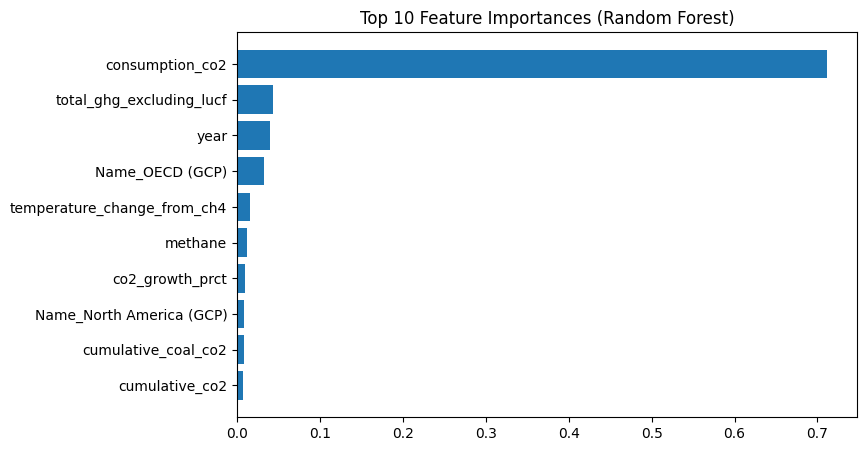

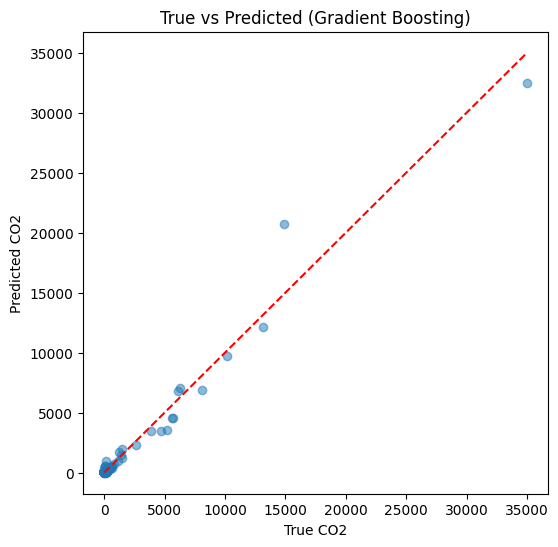

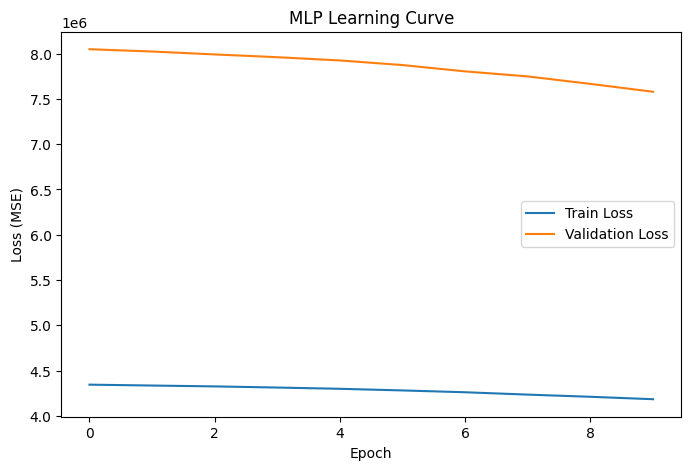

In [3]:
# -----------------------------
# Extra Graphs
# -----------------------------

# 1. Feature importance (Random Forest)
importances = models['RandomForest'].feature_importances_
indices = np.argsort(importances)[-10:]  # top 10
plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

# 2. True vs Predicted (Gradient Boosting)
gb_preds = models['GradientBoosting'].predict(X_test_p)
plt.figure(figsize=(6,6))
plt.scatter(y_test, gb_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True CO2")
plt.ylabel("Predicted CO2")
plt.title("True vs Predicted (Gradient Boosting)")
plt.show()

# 3. MLP Learning Curve
history = mlp.history
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("MLP Learning Curve")
plt.legend()
plt.show()

# 1. Feature Importance

Random Forest and XGBoost models are used to measure which features contribute most to predicting CO₂ emissions.

A horizontal bar chart (top 15 features) is plotted showing the most influential factors.

This gives a global view of what drives the model’s predictions.

# 2. Partial Dependence Plots (PDPs)

PDPs are generated for a few important features.

These plots show the marginal effect of a single feature on the predicted emissions, holding other features constant.

Example: how increasing energy_per_capita impacts CO₂ emissions.

# 3. SHAP Explanations (Global + Local)

Global SHAP summary plot: a scatter plot showing how each feature influences predictions across the dataset.

Features at the top are most important.

The color scale shows whether a high or low feature value increases or decreases emissions.

Local SHAP force plot: for a single sample (e.g., one country-year), the model explanation is broken down into feature contributions:

Features pushing prediction higher (red)

Features pushing prediction lower (blue)

This shows why the model predicted a particular emission value for that sample.

# 4. LIME Explanation (Local)

LIME is used on one test instance.

It approximates the model locally with a simpler model (like a linear model).

The result is a table/visualization listing the top features driving that specific prediction with their positive/negative influence.

# 5. Deep Learning + Integrated Gradients / SHAP

A Multi-Layer Perceptron (MLP) neural network is trained on the same dataset.

The model’s predictions are evaluated with R² and MAE.

Integrated Gradients / Deep SHAP is applied to the MLP:

Produces a feature attribution plot showing which inputs most strongly influenced the neural network’s output.

This ensures interpretability of deep learning models, not just tree-based ones.